# The results of this experiment were run on a laptop (with a 3070 GPU), which is a different machine than the one used in the experiment.

In [157]:
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import torch
import torch.nn as nn
import torch.optim as optim
from operator import truediv
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import torch.nn.functional as F
import PIL
import time
import torchvision
from einops import rearrange
from torch import nn
import torch.nn.init as init
import warnings
warnings.filterwarnings("ignore")


if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    if torch.cuda.device_count() > 1:
        device = torch.device('cuda:0')
    else:
        device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Hyperparameterization

In [158]:
BATCH_SIZE_TRAIN = 100
NUM_CLASS = 9

# Data processing

In [159]:
def applyPCA(X, numComponents):

    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

In [160]:
def padWithZeros(X, margin=2):

    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X

    return newX

In [161]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):

    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1

    return patchesData, patchesLabels

In [162]:
def splitTrainTestSet(X, y, testRatio, randomState=345):


    X_test, X_train, y_test, y_train = train_test_split(X,
                                                        y,
                                                        test_size=testRatio,
                                                        random_state=randomState,
                                                        stratify=y)

    return X_train, X_test, y_train, y_test

In [163]:
class TrainDS(torch.utils.data.Dataset):

    def __init__(self, Xtrain, ytrain):

        self.len = Xtrain.shape[0]
        self.x_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)

    def __getitem__(self, index):


        return self.x_data[index], self.y_data[index]

    def __len__(self):


        return self.len

In [164]:
class TestDS(torch.utils.data.Dataset):

    def __init__(self, Xtest, ytest):

        self.len = Xtest.shape[0]
        self.x_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)

    def __getitem__(self, index):


        return self.x_data[index], self.y_data[index]

    def __len__(self):


        return self.len

In [165]:
def create_data_loader():
    # 地物类别
    # class_num = 16
    # 读入数据

    #Indine
    # X = sio.loadmat(r"E:\zc_paper\five\code_main\data\Indian\Indian_pines_corrected.mat")['indian_pines_corrected']  # X.shape=(145,145,200)
    # y = sio.loadmat(r"E:\zc_paper\five\code_main\data\Indian\Indian_pines_gt.mat")['indian_pines_gt']#[145,145]

    ## PaviaU
    X = sio.loadmat(r"data/PaviaU/PaviaU.mat")[
        'paviaU']  
    y = sio.loadmat(r"data/PaviaU/PaviaU_gt.mat")['paviaU_gt']  

    # #HanChuan
    # X = sio.loadmat(r"E:\zc_paper\five\code_main\data\HanChuan\WHU_Hi_HanChuan.mat")['WHU_Hi_HanChuan']  # 
    # y = sio.loadmat(r"E:\zc_paper\five\code_main\data\HanChuan\WHU_Hi_HanChuan_gt.mat")['WHU_Hi_HanChuan_gt']  #      #X = sio.loadmat('D:\wodewenjian\HSI_dada\PaviaU')['paviaU']


    # ##LongKou
    # X = sio.loadmat(r"E:\zc_paper\five\code_main\data\LongKou\WHU_Hi_LongKou.mat")['WHU_Hi_LongKou']  # X.shape=(145,145,200)
    # y = sio.loadmat(r"E:\zc_paper\five\code_main\data\LongKou\WHU_Hi_LongKou_gt.mat")['WHU_Hi_LongKou_gt']  # [145,145]         #X = sio.loadmat('D:\wodewenjian\HSI_dada\PaviaU')['paviaU']

    # 用于测试样本的比例
    test_ratio = 0.90
    # 每个像素周围提取 patch 的尺寸15
    patch_size = 15
    # 使用 PCA 降维，得到主成分的数量
    pca_components = 30

    print('Hyperspectral data shape: ', X.shape)
    print('Label shape: ', y.shape)

    print('\n... ... PCA tranformation ... ...')
    X_pca = applyPCA(X, numComponents=pca_components)
    print('Data shape after PCA: ', X_pca.shape)

    print('\n... ... create data cubes ... ...')
    X_pca, y_all = createImageCubes(X_pca, y, windowSize=patch_size)
    print('Data cube X shape: ', X_pca.shape)

    print('\n... ... create train & test data ... ...')
    Xtest, Xtrain, ytest, ytrain = splitTrainTestSet(X_pca, y_all, test_ratio)
    print('Xtrain shape: ', Xtrain.shape)
    print('Xtest  shape: ', Xtest.shape)


    X = X_pca.reshape(-1, patch_size, patch_size, pca_components, 1)
    Xtrain = Xtrain.reshape(-1, patch_size, patch_size, pca_components, 1)
    Xtest = Xtest.reshape(-1, patch_size, patch_size, pca_components, 1)
    print('before transpose: Xtrain shape: ', Xtrain.shape)
    print('before transpose: Xtest  shape: ', Xtest.shape)


    X = X.transpose(0, 4, 3, 1, 2)
    Xtrain = Xtrain.transpose(0, 4, 3, 1, 2)
    Xtest = Xtest.transpose(0, 4, 3, 1, 2)
    print('after transpose: Xtrain shape: ', Xtrain.shape)
    print('after transpose: Xtest  shape: ', Xtest.shape)


    X = TestDS(X, y_all)
    trainset = TrainDS(Xtrain, ytrain)
    testset = TestDS(Xtest, ytest)
    train_loader = torch.utils.data.DataLoader(dataset=trainset,
                                               batch_size=BATCH_SIZE_TRAIN,
                                               shuffle=True,
                                               num_workers=0,
                                               )
    test_loader = torch.utils.data.DataLoader(dataset=testset,
                                               batch_size=BATCH_SIZE_TRAIN,
                                               shuffle=False,
                                               num_workers=0,
                                              )
    all_data_loader = torch.utils.data.DataLoader(dataset=X,
                                                batch_size=BATCH_SIZE_TRAIN,
                                                shuffle=False,
                                                num_workers=0,
                                              )

    return train_loader, test_loader, all_data_loader, y

# plot 

In [166]:
def get_classification_map(y_pred, y):

    height = y.shape[0]
    width = y.shape[1]
    k = 0
    cls_labels = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            target = int(y[i, j])
            if target == 0:
                continue
            else:
                cls_labels[i][j] = y_pred[k]+1
                k += 1

    return  cls_labels

def list_to_colormap(x_list):
    y = np.zeros((x_list.shape[0], 3))

    #PaviaU
    for index, item in enumerate(x_list):
        if item == 0:
            y[index] = np.array([0, 0, 0]) / 255.
        if item == 1:
            y[index] = np.array([10, 17, 241]) / 255.
        if item == 2:
            y[index] = np.array([10, 247, 11]) / 255.
        if item == 3:
            y[index] = np.array([10, 247, 241]) / 255.
        if item == 4:
            y[index] = np.array([10, 133, 11]) / 255.
        if item == 5:
            y[index] = np.array([240, 17, 241]) / 255.
        if item == 6:
            y[index] = np.array([159, 91, 48]) / 255.
        if item == 7:
            y[index] = np.array([126, 17, 127]) / 255.
        if item == 8:
            y[index] = np.array([240, 17, 11]) / 255.
        if item == 9:
            y[index] = np.array([240, 247, 11]) / 255.
    return y


def classification_map(map, ground_truth, dpi, save_path):
    fig = plt.figure(frameon=False)
    fig.set_size_inches(ground_truth.shape[1]*2.0/dpi, ground_truth.shape[0]*2.0/dpi)

    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.add_axes(ax)

    ax.imshow(map)
    fig.savefig(save_path, dpi=dpi)

    return 0

def test(device, net, test_loader):
    count = 0
    # 模型测试
    net.eval()
    y_pred_test = 0
    y_test = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = net(inputs)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        if count == 0:
            y_pred_test = outputs
            y_test = labels
            count = 1
        else:
            y_pred_test = np.concatenate((y_pred_test, outputs))
            y_test = np.concatenate((y_test, labels))

    return y_pred_test, y_test

def get_cls_map(net, device, all_data_loader, y):

    y_pred, y_new = test(device, net, all_data_loader)
    cls_labels = get_classification_map(y_pred, y)
    x = np.ravel(cls_labels)
    gt = y.flatten()

    y_list = list_to_colormap(x)
    y_gt = list_to_colormap(gt)

    y_re = np.reshape(y_list, (y.shape[0], y.shape[1], 3))
    gt_re = np.reshape(y_gt, (y.shape[0], y.shape[1], 3))


    # # #PaviaU
    classification_map(y_re, y, 300,
                       r'classification_maps/SSFAN/PU/' + 'PU_predictions.eps')
    classification_map(y_re, y, 300,
                       'classification_maps/SSFAN/PU/' + 'PU_predictions.png')
    classification_map(gt_re, y, 300,
                       'classification_maps/SSFAN/PU/' + 'PU_gt.png')

    print('------Get classification maps successful-------')


# Loss Function

In [167]:
class NormalizedGeneralizedCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0, q=0.7):
        super(NormalizedGeneralizedCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.q = q
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        numerators = 1. - torch.pow(torch.sum(label_one_hot * pred, dim=1), self.q)
        denominators = self.num_classes - pred.pow(self.q).sum(dim=1)
        ngce = numerators / denominators
        return self.scale * ngce.mean()

class NormalizedCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(NormalizedCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.log_softmax(pred, dim=1)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        nce = -1 * torch.sum(label_one_hot * pred, dim=1) / (- pred.sum(dim=1))
        return self.scale * nce.mean()



class NGCEandNCEandLab(torch.nn.Module):
    def __init__(self, alpha, beta,num_classes, q=0.7):
        super(NGCEandNCEandLab, self).__init__()
        self.num_classes = num_classes
        self.ngce = NormalizedGeneralizedCrossEntropy(scale=alpha, q=q, num_classes=num_classes)
        self.nce = NormalizedCrossEntropy(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.ngce(pred, labels) + self.nce(pred, labels)

# SSFAN Model

In [168]:
def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d):
        init.kaiming_normal_(m.weight)

In [169]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

In [170]:
class LayerNormalize(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):

        x = self.norm(x)
        return self.fn(x, **kwargs)

In [171]:
class MLP_Block(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.1): # 64 ,8
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


In [172]:
class SToken(nn.Module):  #97.4 oa:  97.802 #  --> L
    def __init__(self, dim):
        super(SToken, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(inplace=True),
            nn.Sigmoid()
        )
        self.bias = nn.Parameter(torch.zeros(1,1, dim))
        nn.init.xavier_normal_(self.bias)


    def forward(self, x):
        # 在序列维度上进行SE注意力计算
        squeeze_seq =  torch.mean(x, dim=1).unsqueeze(1)

        squeeze_seq = self.fc1(squeeze_seq)

        out = squeeze_seq + self.bias.expand(x.shape[0], -1, -1)
        out = torch.cat((out, x[:,1:,:]), dim=1)
        return out * x

In [173]:
class SSRB(nn.Module):
    def __init__(self,seq_len, d_model):
        super(SSRB, self).__init__()

        self.state_dim = d_model


        self.LN_B = nn.Linear(d_model, d_model) 
        self.LN_C = nn.Linear(d_model, d_model)
        self.LN_delta = nn.Linear(d_model, d_model)  

        self.delta = nn.Parameter(torch.zeros(1, seq_len, d_model)) 
        nn.init.xavier_normal_(self.delta) #yes

        self.A = nn.Parameter(torch.zeros(seq_len, d_model)) 
        nn.init.xavier_normal_(self.A)
        self.ST = SToken(d_model)

        self.Sigmoid = nn.Sigmoid()
        ''' '''

    def forward(self, x): 


        z = self.Sigmoid(x)

        B_0 = self.LN_B(x)
        C_ = self.LN_C(x)
        ''''''

        T_ = self.ST(x)  
        ''''''
        delta = self.LN_delta(x)  
        #delta = F.softplus(delta + self.delta)  
        delta = self.Sigmoid(delta + self.delta)

        A_ = torch.einsum('B L D,L D -> B L D', delta, self.A)
        #A_ = torch.exp(A_)
        B_ = torch.einsum('B L D,B L D->B L D ', delta, B_0)  

        output = []

        s = torch.zeros(x.shape[0], x.shape[2]).cuda()  #

        for t in range(x.shape[1]):
            s = torch.einsum('B D,B D-> B D', A_[:, t,], s) + torch.einsum('B D, B D->B D',
                                                                                      B_[:, t,],
                                                                                      x[:, t, :])  # [batch, D]

            y_pred = torch.einsum('B D,B D-> B D', C_[:, t], s) +T_[:,t,:]
            output.append(y_pred.unsqueeze(1))

        # 预测状态
        x_out = torch.cat(output, dim=1)
        x_out = x_out*z

        ''''''
        return  x_out

In [174]:
class Scan(nn.Module):
    def __init__(self,seq, dim): 
        super().__init__()


    def forward(self, x):


        cen = x.shape[2]//2  #5
        x = rearrange(x, 'b c h w -> b h w c')  
        x_out = torch.zeros(x.shape[0], x.shape[1]*x.shape[2], x.shape[3]).cuda()
        x_out[:, 0, :] = x[:, cen, cen, :]
        for i in range(cen): 

            if(i==0):
               #第1层 2*4=8个
               x_out[:,1:3,:]=x[:,cen-1,cen:cen+2,:]
               x_out[:, 3:5, :] =x[:,cen:cen+2,cen+1,:]
               x_out[:, 5:7, :] =x[:,cen+1,cen-1:cen+1,:]
               x_out[:, 7:9, :] =x[:,cen-1:cen+1,cen-1,:]

            if (i == 1):
               # 第2层 4*4=16个  4
               x_out[:, 9:13, :] = x[:, cen - 2, cen-1:cen + 3, :]
               x_out[:, 13:17, :] = x[:, cen-1:cen + 3, cen + 2, :]
               x_out[:, 17:21, :] = x[:, cen + 2, cen - 2:cen + 2, :]
               x_out[:, 21:25, :] = x[:, cen - 2:cen + 2, cen - 2, :]

            if (i == 2):
                # 第3层 6*4=24个  6
                x_out[:, 25:31, :] = x[:, cen - 3, cen - 2:cen + 4, :]
                x_out[:, 31:37, :] = x[:, cen - 2:cen + 4, cen + 3, :]
                x_out[:, 37:43, :] = x[:, cen + 3, cen - 3:cen + 3, :]
                x_out[:, 43:49, :] = x[:, cen - 3:cen + 3, cen - 3, :]
            if (i == 3):
               # 第4层 8*4=32个  8
               x_out[:, 49:57, :] = x[:, cen - 4, cen - 3:cen + 5, :]
               x_out[:, 57:65, :] = x[:, cen - 3:cen + 5, cen + 4, :]
               x_out[:, 65:73, :] = x[:, cen + 4, cen - 4:cen + 4, :]
               x_out[:, 73:81, :] = x[:, cen - 4:cen + 4, cen - 4, :]
            if (i == 4):
                # 第5层 10*4=40个  10
                x_out[:, 81:91, :] = x[:, cen - 5, cen - 4:cen + 6, :]
                x_out[:, 91:101, :] = x[:, cen - 4:cen + 6, cen + 5, :]
                x_out[:, 101:111, :] = x[:, cen + 5, cen - 5:cen + 5, :]
                x_out[:, 111:121, :] = x[:, cen - 5:cen + 5, cen - 5, :]


        return x_out

In [175]:
class SEMB(nn.Module):
    def __init__(self,seq_len, dim, depth, mlp_dim, dropout): 
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(LayerNormalize(dim, SSRB(seq_len,dim))),
                Residual(LayerNormalize(dim, MLP_Block(dim, mlp_dim, dropout=dropout)))
            ]))

    def forward(self, x, mask=None):
        for semb, mlp in self.layers:
            x = semb(x)  # go to attention
            x = nn.AdaptiveAvgPool1d(1)(x.transpose(1, 2), ).squeeze()  # [B D]
            x = mlp(x)  # go to MLP_Block
        return x

In [176]:
class SSFAN(nn.Module):
    def __init__(self, in_channels=1, patch = 15, dim=NUM_CLASS, depth=1, mlp_dim=8, dropout=0.1, emb_dropout=0.1):
        super(SSFAN, self).__init__()

        self.conv3d_features = nn.Sequential(
            nn.Conv3d(in_channels, out_channels=8, kernel_size=(3, 3, 3)),
            nn.BatchNorm3d(8),
            nn.ReLU(),
        )

        self.conv2d_features = nn.Sequential(
            nn.Conv2d(in_channels=8*28, out_channels=dim, kernel_size=(3, 3)),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
        )
        
        self.conv3d_features1 = nn.Sequential(
            nn.Conv3d(in_channels, out_channels=8, kernel_size=(3, 3, 3)),
            nn.BatchNorm3d(8),
            nn.ReLU(),
        )

        self.conv2d_features1 = nn.Sequential(
            nn.Conv2d(in_channels=8*28, out_channels=dim, kernel_size=(3, 3)),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
        )

        self.pos_embedding = nn.Parameter(torch.empty(1, ((patch-4 ) ** 2 + 1), dim))
        torch.nn.init.uniform_(self.pos_embedding)#, std=.02

        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        self.scan = Scan(seq = (patch-4 ) ** 2 + 1,  dim=dim)
        self.STMambaBlock = SEMB((patch - 4) ** 2 + 1, dim, depth, mlp_dim, dropout)



    def forward(self, x, mask=None): 
        x1 = x

        x = self.conv3d_features(x) 

        x = rearrange(x, 'b c h w y -> b (c h) w y') 
        x = self.conv2d_features(x) 

        x1 = self.conv3d_features1(x1)  

        x1 = rearrange(x1, 'b c h w y -> b (c h) w y')  
        x1 = self.conv2d_features1(x1)  

        x = x + x1



        x = self.scan(x)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)

        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.dropout(x)

        x = self.STMambaBlock(x, mask)  
 

        if(x.shape[0]==16 or x.shape[0]==21):
            x = x.unsqueeze(0)  


        return x

# evaluations of SSFAN

In [177]:
def AA_andEachClassAccuracy(confusion_matrix):

    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

def acc_reports(y_test, y_pred_test):


    target_names = ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Painted metal sheets',
                    'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows']



    classification = classification_report(y_test, y_pred_test, digits=4, target_names=target_names)
    oa = accuracy_score(y_test, y_pred_test)
    confusion = confusion_matrix(y_test, y_pred_test)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(y_test, y_pred_test)

    return classification, oa*100, confusion, each_acc*100, aa*100, kappa*100

# Test、Train Functions

In [178]:
def test(device, net, test_loader):
    count = 0
    # 模型测试
    net.eval()
    y_pred_test = 0
    y_test = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = net(inputs)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        if count == 0:
            y_pred_test = outputs
            y_test = labels
            count = 1
        else:
            y_pred_test = np.concatenate((y_pred_test, outputs))
            y_test = np.concatenate((y_test, labels))

    return y_pred_test, y_test

In [179]:
def train(train_loader, epochs):

    # 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('device: ', device)
    # 网络放到GPU上
    net = SSFAN().to(device)
    # 交叉熵损失函数
    criterion = NGCEandNCEandLab(alpha=1.0, beta=1.0, num_classes=9, q=0.7)#############################################3
    # 初始化优化器
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    # 开始训练
    total_loss = 0
    for epoch in range(epochs):#
        net.train()
        for i, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
    
          
            outputs = net(data)
         
            loss = criterion(outputs, target)
        
            optimizer.zero_grad()
         
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]' % (epoch + 1,
                                                                         total_loss / (epoch + 1),
                                                                         loss.item()))

        if ((epoch + 1) % 5 == 0 and (epoch + 1) >= 60):
            y_pred_test, y_test = test(device, net, test_loader)
            classification, oa, confusion, each_acc, aa, kappa = acc_reports(y_test, y_pred_test)
            #print('oa: ', oa), print('aa: ', aa), print('kappa: ', kappa)
            if(oa>95.5):
               print('classification: ', classification)

    print('Finished Training')

    return net, device

Hyperspectral data shape:  (610, 340, 103)
Label shape:  (610, 340)

... ... PCA tranformation ... ...
Data shape after PCA:  (610, 340, 30)

... ... create data cubes ... ...
Data cube X shape:  (42776, 15, 15, 30)

... ... create train & test data ... ...
Xtrain shape:  (4277, 15, 15, 30)
Xtest  shape:  (38499, 15, 15, 30)
before transpose: Xtrain shape:  (4277, 15, 15, 30, 1)
before transpose: Xtest  shape:  (38499, 15, 15, 30, 1)
after transpose: Xtrain shape:  (4277, 1, 30, 15, 15)
after transpose: Xtest  shape:  (38499, 1, 30, 15, 15)
device:  cuda:0
[Epoch: 1]   [loss avg: 2.0479]   [current loss: 0.0183]
[Epoch: 2]   [loss avg: 1.3178]   [current loss: 0.0069]
[Epoch: 3]   [loss avg: 0.9637]   [current loss: 0.0043]
[Epoch: 4]   [loss avg: 0.7683]   [current loss: 0.0031]
[Epoch: 5]   [loss avg: 0.6377]   [current loss: 0.0059]
[Epoch: 6]   [loss avg: 0.5461]   [current loss: 0.0011]
[Epoch: 7]   [loss avg: 0.4775]   [current loss: 0.0027]
[Epoch: 8]   [loss avg: 0.4238]   [cur

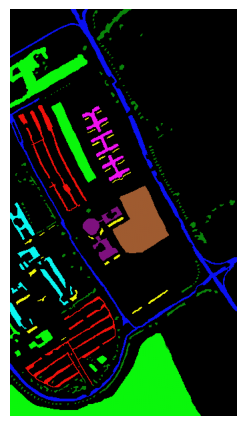

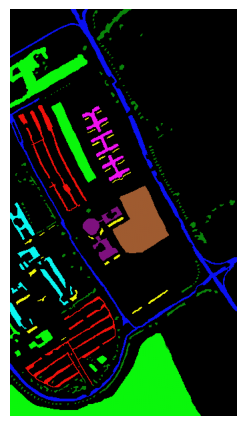

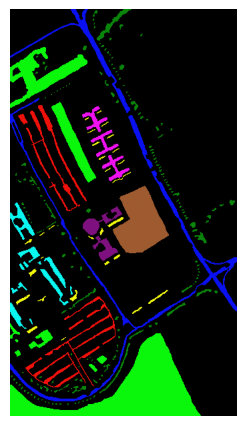

In [180]:
if __name__ == '__main__':

    train_loader, test_loader, all_data_loader, y_all= create_data_loader()
    tic1 = time.perf_counter()
    net, device = train(train_loader, epochs=100)


    torch.save(net.state_dict(), r'cls_params/SSFAN/PU/param.pth')



    toc1 = time.perf_counter()
    tic2 = time.perf_counter()
    y_pred_test, y_test = test(device, net, test_loader)
    toc2 = time.perf_counter()
    # 评价指标
    classification, oa, confusion, each_acc, aa, kappa = acc_reports(y_test, y_pred_test)
    classification = str(classification)
    Training_Time = toc1 - tic1
    Test_time = toc2 - tic2
    print(classification)
    toc1 = time.perf_counter()
    tic2 = time.perf_counter()
    y_pred_test, y_test = test(device, net, test_loader)
    toc2 = time.perf_counter()
    # 评价指标
    classification, oa, confusion, each_acc, aa, kappa = acc_reports(y_test, y_pred_test)
    classification = str(classification)
    # # #PaviaU
    file_name = r"cls_results/SSFAN/PU/classification_report.txt"




    with open(file_name, 'w') as x_file:
        x_file.write('{} Training_Time (s)'.format(Training_Time))
        x_file.write('\n')
        x_file.write('{} Test_time (s)'.format(Test_time))
        x_file.write('\n')
        x_file.write('{} Kappa accuracy (%)'.format(kappa))
        x_file.write('\n')
        x_file.write('{} Overall accuracy (%)'.format(oa))
        x_file.write('\n')
        x_file.write('{} Average accuracy (%)'.format(aa))
        x_file.write('\n')
        x_file.write('{} Each accuracy (%)'.format(each_acc))
        x_file.write('\n')
        x_file.write('{}'.format(classification))
        x_file.write('\n')
        x_file.write('{}'.format(confusion))
    

    #print('y_test: ',y_test),print('y_test_size: ',y_test.size)
    print('oa: ', oa), print('aa: ', aa), print('kappa: ', kappa)

    get_cls_map(net, device, all_data_loader, y_all)